In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../utils")
import toolbox_ML as tb
import seaborn as sns
import funciones as fun

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier


import pickle

### 1. Obtención de los datos

In [499]:
df=pd.read_csv('../data_sample/ai4i2020.csv')


### 2. Entendiendo los datos y el problema

#### 2.1 Datos

Los datos que tenemos son distintas mediciones de obtenidas de una máquina entre las cuales están reesgistros tomados antes de que la máquina  falle, Los valores de medición que nos propociona son:
- Type (tipo de producto.)
- Air temperature
- Process temperatura
- Rotationa speed
- Torque
- Tool Wear

veremos que hay variables que dada su naturaleza tendremos que tratar, y crearemos nuevas a partir de las que tenemos.

Despues tenemos la variable Machine Failure que indica si la máquina ha fallado 

Y por último tenemos los diferentes tipos de Fallos.

- TWF: Fallo por desgaste de la herramienta.
- HDF: Fallo por disipación de calor.
- PWF: Fallo de potencia
- OSF: Fallo por sobrecarga si el prodçucto se desgasta
- RNF: Fallo aleatorio, sin especificar el origen

En cuanto a los tipos de fallos y si la máquina falla hay un desajuste que es necesario resolver.

#### 2.2 Problema

El problema que debemos resolver es hacer un modelo que prediga cuando una máquina va a fallar, para que esta entre en un modo mantenimiento o pausa y no genere se llegue a estropear. es decir, poner remedio antes de que se cause el problema. También vamos a clasificar ese fallo para que sea más fácil su tratamiento.


In [500]:
df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0


##### Cambio de nombre de variables
Para que sea más cómodo trabar he cambiado el nombre de algunas variables.

In [501]:
# Renombrar Columnas para que sea más cómodo trabajar con ellas
df.rename(columns = {'Product ID':'Product_ID',
                    'Air temperature [K]':'Air_temperature',
                     'Process temperature [K]':'Process_temperature',
                     'Rotational speed [rpm]':'Rotational_speed',
                     'Torque [Nm]':'Torque',
                     'Tool wear [min]':'Tool_wear',
                     'Machine failure':'Machine_failure',},
          inplace = True)

#### 3-Primera exploración de datos
En la primera exploración de datos vemos que tenemos 10000 registros y 13 registros.

No contiene valores nulos.

Los fallos están representados con 0 i 1, 

En cuanto a los valores númericos los analizaremos más adelante para ver su distibución.

En los siguientes pasos me he centrado en analizar y ajustar las variables  de fallos.

In [502]:
df.head()

,UDI,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [503]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UDI                  10000 non-null  int64  
 1   Product_ID           10000 non-null  object 
 2   Type                 10000 non-null  object 
 3   Air_temperature      10000 non-null  float64
 4   Process_temperature  10000 non-null  float64
 5   Rotational_speed     10000 non-null  int64  
 6   Torque               10000 non-null  float64
 7   Tool_wear            10000 non-null  int64  
 8   Machine_failure      10000 non-null  int64  
 9   TWF                  10000 non-null  int64  
 10  HDF                  10000 non-null  int64  
 11  PWF                  10000 non-null  int64  
 12  OSF                  10000 non-null  int64  
 13  RNF                  10000 non-null  int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 1.1+ MB


In [504]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air_temperature,10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process_temperature,10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational_speed,10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque,10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool_wear,10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine_failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


##### 3.1 Ajuste de la variables de registro de fallos
Primero de todo he comprobado que cuando una máquina falla esta registrado tanto en el campo "Machine_failure" como su tipo de fallo y a la inversa ( si hay registrado un tipo de fallo tiene que estar registrado en "Machine_failure"), pero he visto que hay un desajuste.

También he visto que una máquina puede tener 2 o más tipos de fallos a la vez. por lo que he creado una nueva variable con los diferentes tipos de fallos

En las siguientes lineas de código queda registrado el paso a paso.

In [505]:
#Hay un desajuste entre las columnas de fallos y la columna Machine_failure
columnas_fallos=['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

print(f'Suma total de todas las columnas de fallos: {df[columnas_fallos].sum().sum()}')
print(f"Suma total de la columna Machine_failure: {df.Machine_failure.sum()}")

Suma total de todas las columnas de fallos: 373
Suma total de la columna Machine_failure: 339


In [506]:
#creamos una columna auxiliar para sumar los fallos
df['Total_Failures'] = df[columnas_fallos].sum(axis=1)


In [507]:
#Si hay fallo en la máquina y no hay fallos en los tipos de fallos, 
# entonces se considera que hay un fallo de tipo RNF (fallo Aleatorio)
df.loc[(df['Machine_failure'] == 1) & 
       (df[columnas_fallos].sum(axis=1) == 0), 'RNF'] = 1


In [508]:
# si las columnas tipos de fallo tienen un valor de 1, 
# entonces se considera que hay un fallo en la máquina
for i in columnas_fallos:
    df.loc[df[i] == 1, 'Machine_failure'] = 1
df.Machine_failure.sum()

np.int64(357)

In [509]:
#Si hay mas de un tipo fallo en la máquina, entonces se considera que hay un fallo múltiple
#como El dataset utilizad siglas para definir los tipos de fallos haremos los propio con Fallos Múltiples
#FM ----> Fallo Múltiple
df['FM'] = (df['Total_Failures'] > 1).astype(int)


In [510]:
#Los fallos múltiples no pueden tener fallos individuales
df.loc[df.FM==1, columnas_fallos] = 0

In [512]:
#Borrado de la columna Total_Failures ya que no la vamos a volver a usar
df.drop(columns=['Total_Failures'], inplace=True)

KeyError: "['Total_Failures'] not found in axis"

In [513]:
# Volvemos a comparar la columna Machine_failure con la suma de las columnas de fallos y ahora sí, tenemos los mismos valores 
print(f'Suma total de todas las columnas de fallos: {df[columnas_fallos + ["FM"]].sum().sum()}')
print(f"Suma total de la columna Machine_failure: {df['Machine_failure'].sum()}")

Suma total de todas las columnas de fallos: 357
Suma total de la columna Machine_failure: 357


#### 3.2 Analisis de las variables de fallos
En los siguientes graficos muestro la distribución de la Variable Machine_ failure ( si una máquina falla o no)Y la distrubución de los diferentes fallos. 

Dados estos datos he tomado la decisión de crear dos modelos. 

- El primero predice si hay un fallo o no, 
- El segundo clasifica el tipo de error.

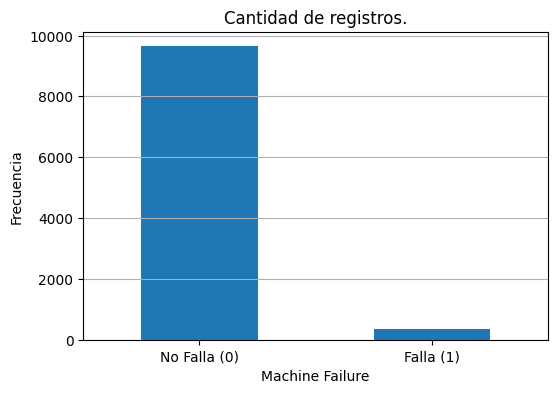

In [514]:
#Gráfico que muestra la cantidad de fallos
# Contar la frecuencia de Machine_failure
failure_distribution = df['Machine_failure'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(6,4))
failure_distribution.plot(kind='bar')
plt.xlabel("Machine Failure")
plt.ylabel("Frecuencia")
plt.title("Cantidad de registros.")
plt.xticks(ticks=[0,1], labels=['No Falla (0)', 'Falla (1)'], rotation=0)
plt.grid(axis='y')

plt.show()


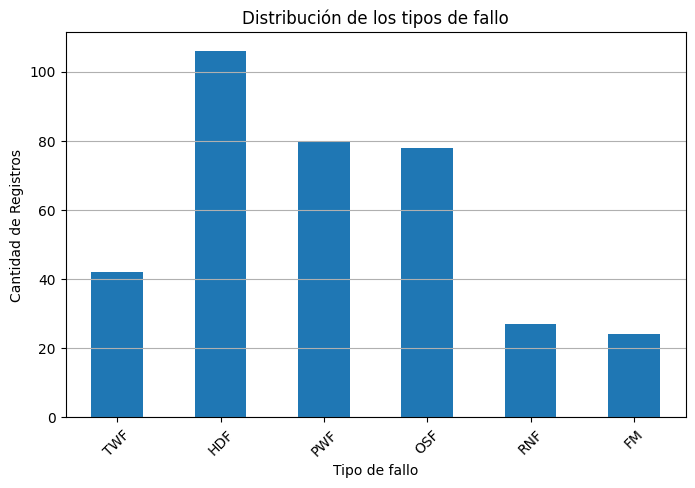

In [169]:
#grafico que muestra la distribución de los tipos de fallos
# Contar la frecuencia de cada tipo de fallo
failure_counts = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF','FM']].sum()

# Crear el gráfico de barras
plt.figure(figsize=(8,5))
failure_counts.plot(kind='bar')
plt.xlabel("Tipo de fallo")
plt.ylabel("Cantidad de Registros")
plt.title("Distribución de los tipos de fallo")
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


#### 4. Separar datos en 2 datasets
- X_primario Dataset eliminando los datos tipos y quedandonos con Machine_Failures como target. (lo usaremos para predecir si una máquina falla o no)
- Y_primario Dataset cuando una maquina a fallado ( lo usaremos para clasificar el tipo de fallo)


In [ ]:
# Separaramos los datos del primer dataset
primario_df = df.drop(columns=['TWF', 'HDF', 'PWF', 'OSF', 'RNF','FM'])


In [623]:
primario_df.head()

,UDI,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure
0,1,M14860,M,298.1,308.6,1551,42.8,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0


In [624]:
secundario_df.head()

,UDI,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,HDF,PWF,OSF,RNF,FM
50,51,L47230,L,298.9,309.1,2861,4.6,143,0,0,1,0,0,0
69,70,L47249,L,298.9,309.0,1410,65.7,191,0,0,0,0,0,1
77,78,L47257,L,298.8,308.9,1455,41.3,208,1,0,0,0,0,0
160,161,L47340,L,298.4,308.2,1282,60.7,216,0,0,0,1,0,0
161,162,L47341,L,298.3,308.1,1412,52.3,218,0,0,0,1,0,0


### PRIMER MODELO

#### 5. Separan los datos en train y test del primer modelo

In [625]:
X_primario = primario_df.drop(columns=['Machine_failure'])
y_primario = primario_df['Machine_failure']

In [769]:
X_primario

,UDI,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear
0,1,M14860,M,298.1,308.6,1551,42.8,0
1,2,L47181,L,298.2,308.7,1408,46.3,3
2,3,L47182,L,298.1,308.5,1498,49.4,5
3,4,L47183,L,298.2,308.6,1433,39.5,7
4,5,L47184,L,298.2,308.7,1408,40.0,9
...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14
9996,9997,H39410,H,298.9,308.4,1632,31.8,17
9997,9998,M24857,M,299.0,308.6,1645,33.4,22
9998,9999,H39412,H,299.0,308.7,1408,48.5,25


In [627]:
X_train, X_test, y_train, y_test = train_test_split(X_primario, y_primario, test_size=0.2, stratify=y_primario, random_state=42)

#### 6 Aplicar transformaciones a los datos
Para la aplicación de transformaciones he creado funciones para poder usar en los dos modelos, tanto en train como en test


##### 6.1 Eliminar columnas inncesarias
Eliminamos las columnas que no aportan información


In [628]:
##Función para eliminar columnas innecesarias
def Eliminar_variables(df):
    """
    Elimina las variables que no son necesarias para el modelo
    """
    df.drop(columns=['Product_ID','UDI'], inplace=True)
    return df

In [629]:
X_train = Eliminar_variables(X_train)

##### 6.2 Crear Columnas que puede aportar informacion
Columna Power_w y columna diferencia de temperatura

In [630]:
##Función para crear nuevas variables
def Crear_variable_potencia(df):
    """
    Crea nuevas variables a partir de las variables existentes
    """
    # Calculo de potencia
    # La potencia se calcula como el producto del par motor y la velocidad angular para ello se ha de convertir de rpm a rad/s
    df['Power_W'] = df.Torque * (df.Rotational_speed * (2 * np.pi / 60))
    return df


In [631]:
X_train = Crear_variable_potencia(X_train)

In [632]:
# Crear una nueva variable que sea la diferencia entre la temperatura del aire y la temperatura del proceso
def Crear_variable_dif_temperadra(df):    
    df['Temp_Diff'] =  df.Process_temperature-df.Air_temperature
    
    return df

In [633]:
X_train = Crear_variable_dif_temperadra(X_train)

##### 6.3 codificar la variable Type mediante get_dummies


In [634]:
#Tratamos la variable categorica Type para convertirla en variables dummy
# Se eliminan las variables innecesarias
def tratar_type(df):
    df =  pd.get_dummies(df, columns=['Type'], dtype=int)
    return df


In [635]:
X_train = tratar_type(X_train)

##### 6.4 listamos las variables numericas para tratar

In [636]:
num_cols = [
    'Air_temperature', 
    'Process_temperature', 
    'Rotational_speed', 
    'Torque', 
    'Tool_wear',
    'Power_W',
    'Temp_Diff',
]

In [637]:
X_train

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Power_W,Temp_Diff,Type_H,Type_L,Type_M
3831,302.3,310.9,1742,29.7,137,5417.927859,8.6,0,0,1
3212,300.3,309.2,1649,32.4,50,5594.925189,8.9,0,1,0
7813,300.0,311.5,1455,41.7,130,6353.714062,11.5,0,1,0
8107,300.3,311.9,1390,49.0,194,7132.462521,11.6,1,0,0
1311,298.9,310.1,1587,30.2,162,5018.945592,11.2,0,1,0
...,...,...,...,...,...,...,...,...,...,...
7390,299.7,310.5,1490,41.2,126,6428.536327,10.8,0,0,1
9799,298.5,309.3,1551,34.7,121,5635.985805,10.8,0,0,1
1440,298.8,309.9,1741,27.7,50,5050.183494,11.1,0,0,1
9835,298.4,309.3,1545,36.9,3,5970.125599,10.9,0,1,0


#### 6.5 Tratar outliers
Ahora analizo las variables donde hay outliers cuando la máquina no ha fallado.

Esto es debido a que los valores atipicos con fallo, son los que suelen ser los causantes de un error en la máquina.




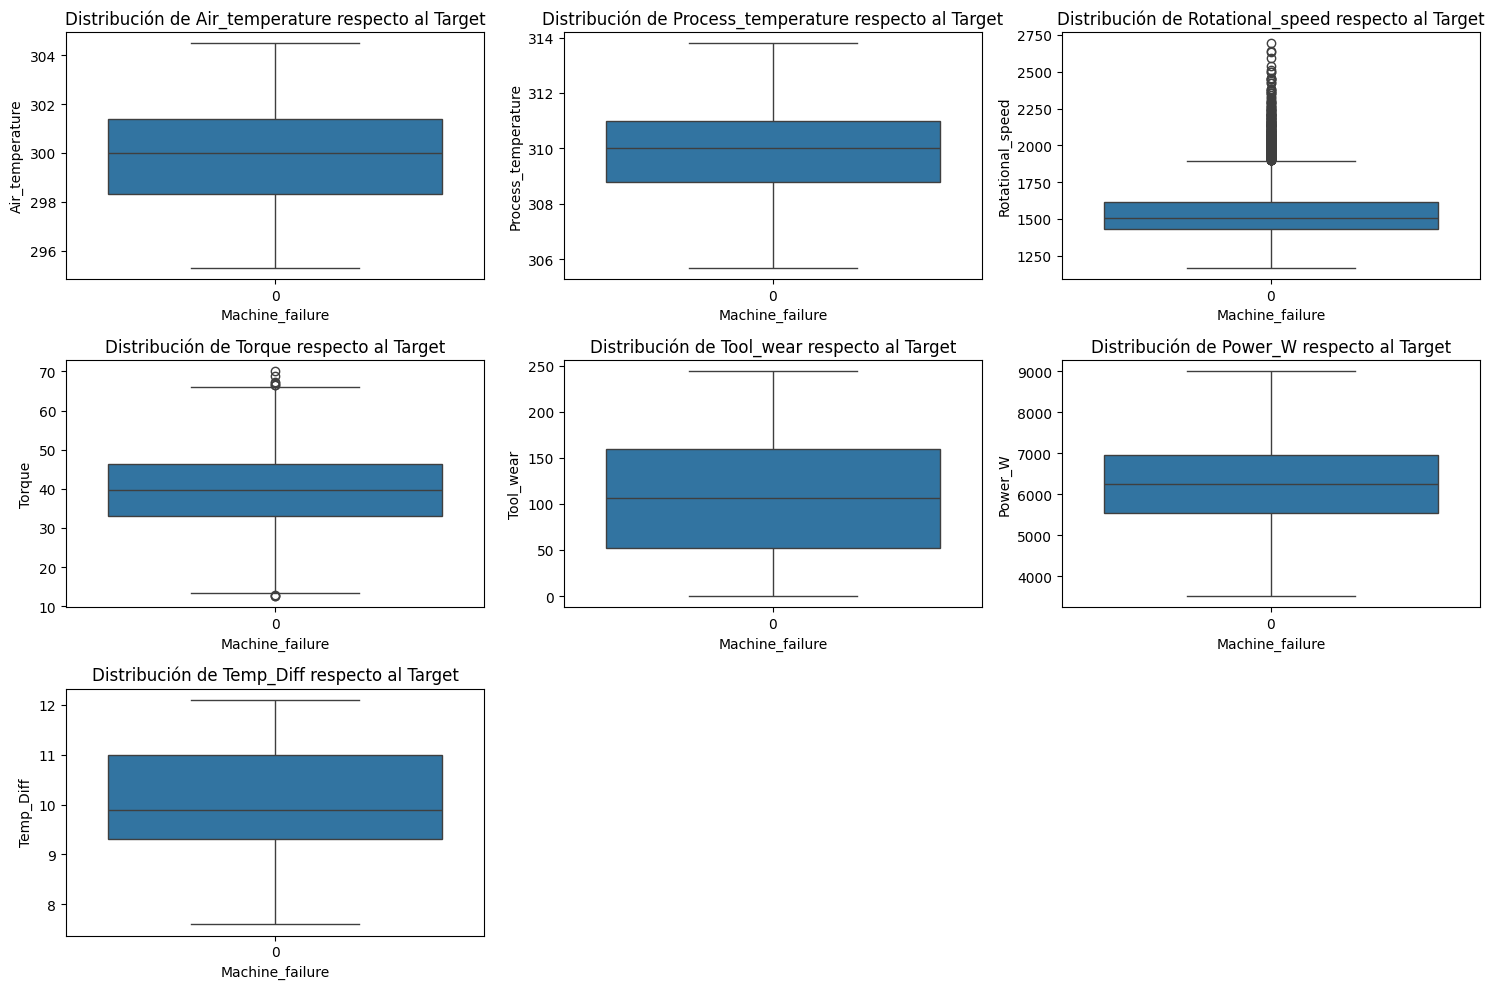

In [638]:
# Unir X_train e y_train en un DataFrame temporalmente
df_temp = X_train.copy()
df_temp['Machine_failure'] = y_train  # Agregamos la columna objetivo

# Filtrar solo los registros donde Machine_failure == 0
df_temp = df_temp[df_temp["Machine_failure"] == 0]

# Graficar las distribuciones usando boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df_temp['Machine_failure'], y=df_temp[col])
    plt.title(f'Distribución de {col} respecto al Target')
plt.tight_layout()
plt.show()




In [639]:
cols_outliers = ['Torque', 'Rotational_speed']

In [640]:
def tratamiento_outliers(X_train, y_train, cols_outliers):
    # Ensure X_train is a DataFrame
    if isinstance(X_train, tuple):
        X_train = X_train[0]  # Extract the DataFrame from the tuple

    Q1 = X_train[cols_outliers].quantile(0.25)
    Q3 = X_train[cols_outliers].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites de outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Crear una máscara booleana de valores atípicos
    outliers = ((X_train[cols_outliers] < lower_bound) | (X_train[cols_outliers] > upper_bound)).any(axis=1)

    # Filtrar solo los outliers sin fallos de máquina
    outliers_no_failure = X_train[(outliers) & (y_train == 0)]

    # Eliminar estos outliers de X_train e y_train
    X_train = X_train.drop(outliers_no_failure.index).reset_index(drop=True)
    y_train = y_train.drop(outliers_no_failure.index).reset_index(drop=True)

    return X_train, y_train



In [641]:
X_train,y_train = tratamiento_outliers(X_train, y_train,cols_outliers)

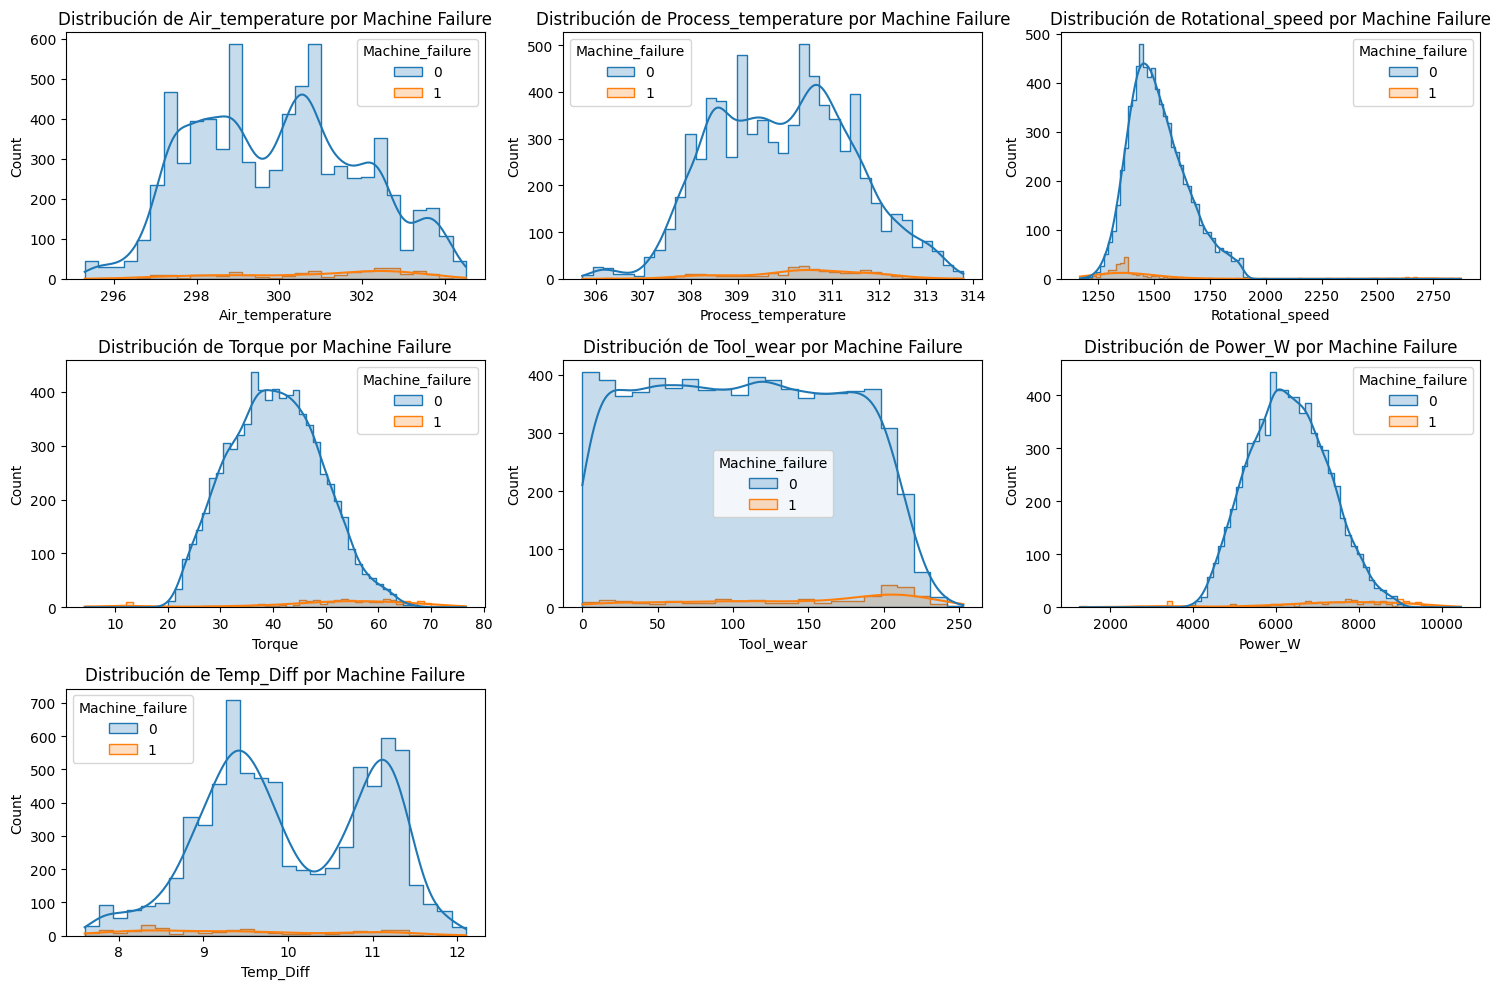

In [642]:
# Histogramas
plt.figure(figsize=(15, 10))

for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=X_train, x=col, hue=y_train, element='step', kde=True)
    plt.title(f'Distribución de {col} por Machine Failure')
plt.tight_layout()
plt.show()


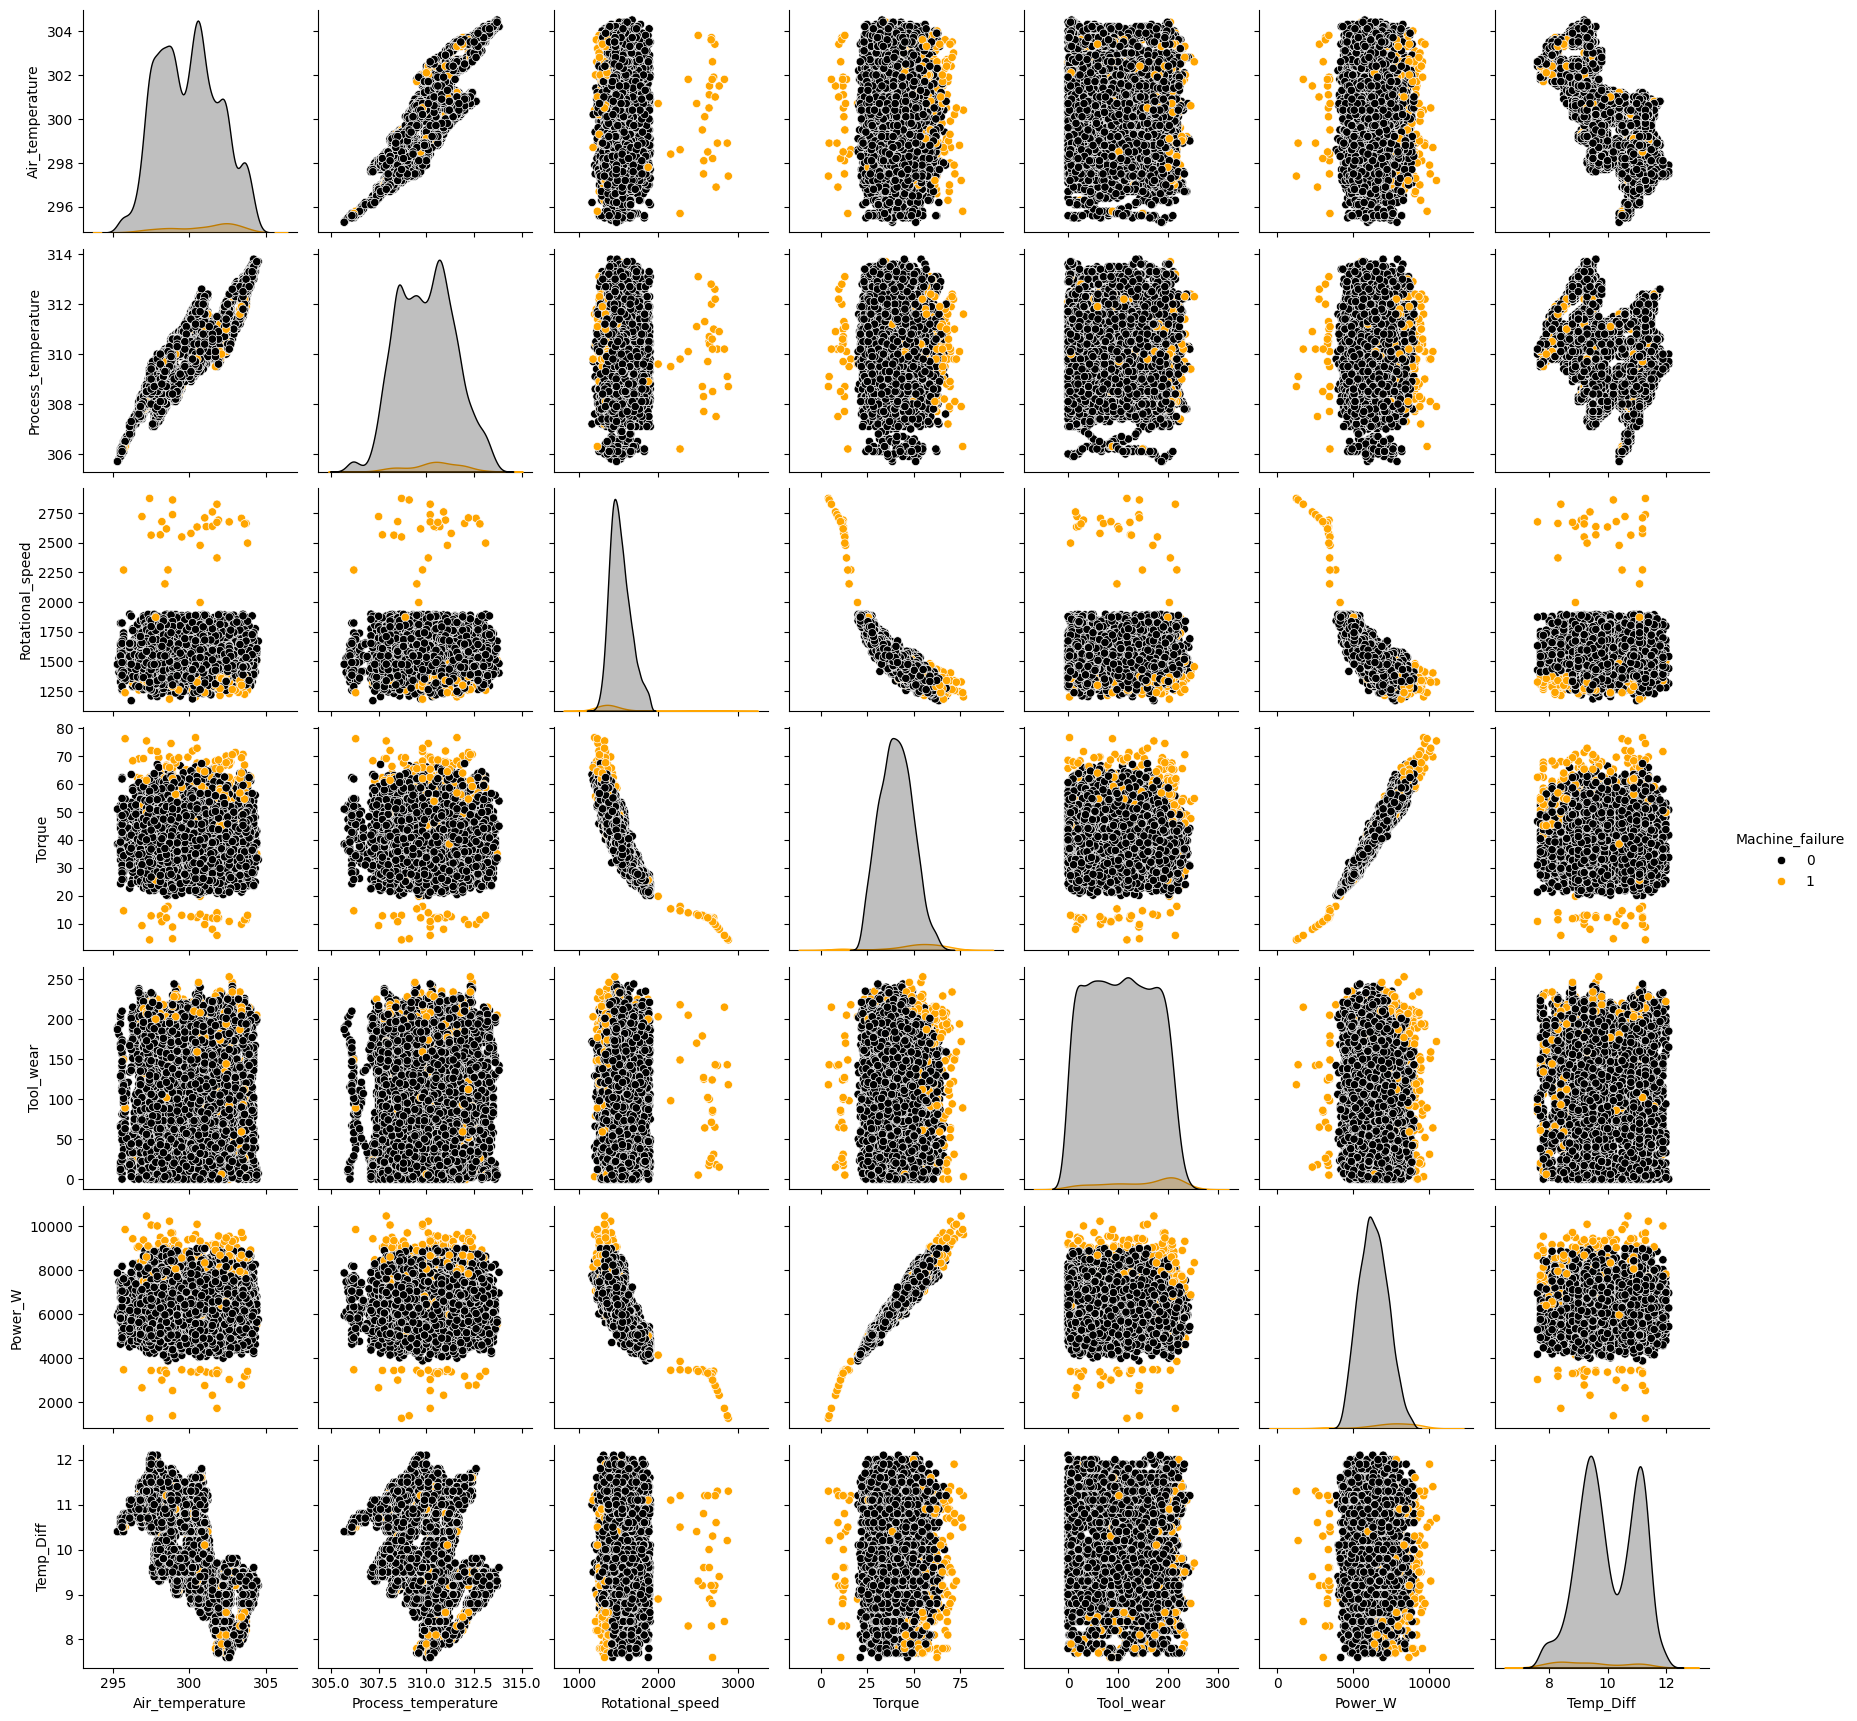

In [643]:
# Generating pairplot

# Unir X_train con y_train para hacer el pairplot
df_train = pd.concat([X_train[num_cols], y_train], axis=1)

# Generar el pairplot
sns.pairplot(df_train, hue='Machine_failure', palette={0: 'black', 1: 'orange'})
plt.show()

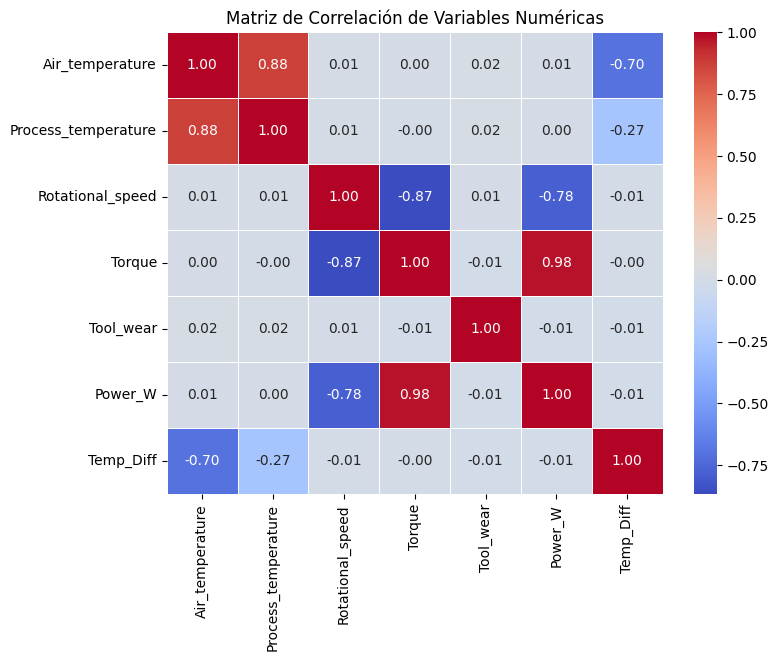

In [644]:
# Calcular la matriz de correlación
corr_matrix = X_train[num_cols].corr()

# Visualizar con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()


In [ ]:
#variables_correlacionadas_elimiar = ['Air_temperature','Torque' ]

In [ ]:
#X_train.drop(columns=variables_correlacionadas_elimiar, inplace=True)

In [647]:
X_train.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Power_W,Temp_Diff,Type_H,Type_L,Type_M
0,302.3,310.9,1742,29.7,137,5417.927859,8.6,0,0,1
1,300.3,309.2,1649,32.4,50,5594.925189,8.9,0,1,0
2,300.0,311.5,1455,41.7,130,6353.714062,11.5,0,1,0
3,300.3,311.9,1390,49.0,194,7132.462521,11.6,1,0,0
4,298.9,310.1,1587,30.2,162,5018.945592,11.2,0,1,0


##### 6.5 Aplicamos las mismas modificaciones a test

In [648]:
# Aplicar SMOTE para balancear el dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [789]:


# Definir el modelo base
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar con Cross-Validation
cv_scores = cross_val_score(rf, X_resampled, y_resampled, cv=cv, scoring='balanced_accuracy')
print(f'Balanced_accuracy promedio en Cross-Validation: {np.mean(cv_scores):.4f}')

# Definir hiperparámetros a buscar
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Mejor modelo encontrado
best_rf = grid_search.best_estimator_


F1-Score promedio en Cross-Validation: 0.9831
Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [791]:
best_rf

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=5, random_state=42)

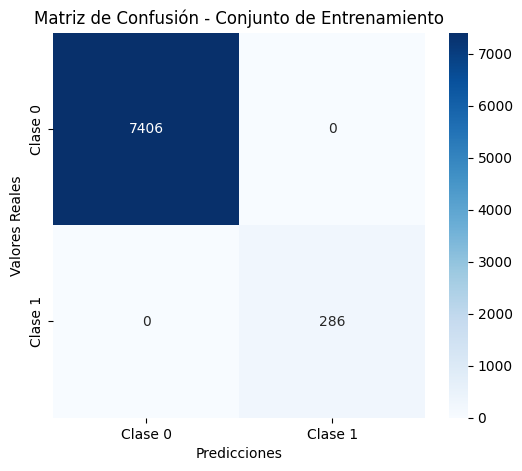

In [ ]:
# Generar predicciones en el conjunto de entrenamiento usando el mejor modelo encontrado
y_train_pred = best_rf.predict(X_train)

# Crear la matriz de confusión
cm = confusion_matrix(y_train, y_train_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión - Conjunto de Entrenamiento')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()


Carga de datos y primer analisis


#### 8  hacemos las modificaciones a test

In [793]:
X_test.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Power_W,Temp_Diff,Type_H,Type_L,Type_M
0,297.8,309.0,1403,64.2,0,9432.380615,11.2,0,1,0
1,298.1,307.9,1446,42.8,121,6480.979981,9.8,0,0,1
2,303.7,312.4,1474,38.8,139,5989.048459,8.7,0,0,1
3,299.9,310.1,1681,29.1,197,5122.586733,10.2,0,1,0
4,300.4,309.3,1525,39.6,202,6324.026012,8.9,0,1,0


In [794]:
X_test=Eliminar_variables(X_test)
X_test=Crear_variable_potencia(X_test)
X_test=Crear_variable_dif_temperadra(X_test)
X_test=tratar_type(X_test)

KeyError: "['Product_ID', 'UDI'] not found in axis"

In [656]:
X_test,y_test = tratamiento_outliers(X_test, y_test,cols_outliers)

In [ ]:
#X_test.drop(columns=variables_correlacionadas_elimiar, inplace=True)

In [657]:
X_test.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Power_W,Temp_Diff,Type_H,Type_L,Type_M
0,297.8,309.0,1403,64.2,0,9432.380615,11.2,0,1,0
1,298.1,307.9,1446,42.8,121,6480.979981,9.8,0,0,1
2,303.7,312.4,1474,38.8,139,5989.048459,8.7,0,0,1
3,299.9,310.1,1681,29.1,197,5122.586733,10.2,0,1,0
4,300.4,309.3,1525,39.6,202,6324.026012,8.9,0,1,0


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1850
           1       0.66      0.80      0.73        71

    accuracy                           0.98      1921
   macro avg       0.83      0.89      0.86      1921
weighted avg       0.98      0.98      0.98      1921

Balanced Accuracy en el conjunto de prueba: 0.8936


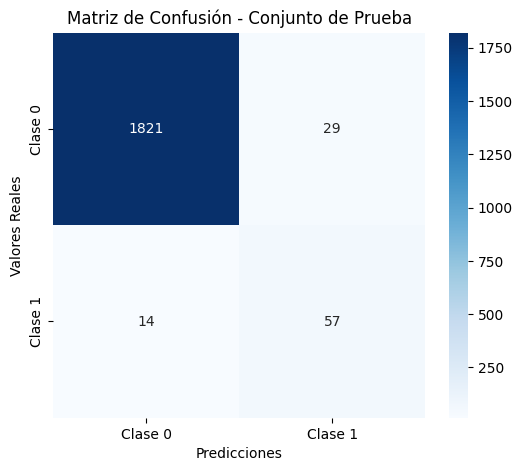

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Realizar predicciones en el conjunto de prueba
y_test_pred = best_rf.predict(X_test)

# Evaluar el rendimiento del modelo
print("Reporte de clasificación:")
print(classification_report(y_test, y_test_pred))

# Calcular la balanced accuracy
balanced_acc_test = balanced_accuracy_score(y_test, y_test_pred)
print(f'Balanced Accuracy en el conjunto de prueba: {balanced_acc_test:.4f}')

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión - Conjunto de Prueba')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()


In [659]:
with open('../models/modelo_1.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

### SEGUNDO MODELO.

In [818]:
secundario_df = df[df['Machine_failure'] == 1].copy()
secundario_df.drop(columns=['Machine_failure'], inplace=True)   


In [819]:
secundario_df.head()

,UDI,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,HDF,PWF,OSF,RNF,FM,Tipo_Fallo,target
50,51,L47230,L,298.9,309.1,2861,4.6,143,0,0,1,0,0,0,PWF,3
69,70,L47249,L,298.9,309.0,1410,65.7,191,0,0,0,0,0,1,FM,0
77,78,L47257,L,298.8,308.9,1455,41.3,208,1,0,0,0,0,0,TWF,5
160,161,L47340,L,298.4,308.2,1282,60.7,216,0,0,0,1,0,0,OSF,2
161,162,L47341,L,298.3,308.1,1412,52.3,218,0,0,0,1,0,0,OSF,2


In [820]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report




In [821]:
secundario_df.head()

,UDI,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,HDF,PWF,OSF,RNF,FM,Tipo_Fallo,target
50,51,L47230,L,298.9,309.1,2861,4.6,143,0,0,1,0,0,0,PWF,3
69,70,L47249,L,298.9,309.0,1410,65.7,191,0,0,0,0,0,1,FM,0
77,78,L47257,L,298.8,308.9,1455,41.3,208,1,0,0,0,0,0,TWF,5
160,161,L47340,L,298.4,308.2,1282,60.7,216,0,0,0,1,0,0,OSF,2
161,162,L47341,L,298.3,308.1,1412,52.3,218,0,0,0,1,0,0,OSF,2


In [822]:
col_fallos=["TWF","HDF","PWF","OSF","RNF","FM"]

In [823]:
fallo_dict = {
    "FM": 0,
    "RNF": 1,
    "OSF": 2,
    "PWF": 3,
    "HDF": 4,
    "TWF": 5
}

In [824]:

# Paso 2: Crear la columna target con los números asignados
secundario_df["Tipo_Fallo"] = secundario_df[col_fallos].idxmax(axis=1)
secundario_df["target"] = secundario_df["Tipo_Fallo"].map(fallo_dict)

# Verificación
secundario_df[["Tipo_Fallo", "target"]].head(10)


,Tipo_Fallo,target
50,PWF,3
69,FM,0
77,TWF,5
160,OSF,2
161,OSF,2
168,PWF,3
194,PWF,3
207,PWF,3
242,OSF,2
248,OSF,2


In [825]:
secundario_df.head()

,UDI,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,HDF,PWF,OSF,RNF,FM,Tipo_Fallo,target
50,51,L47230,L,298.9,309.1,2861,4.6,143,0,0,1,0,0,0,PWF,3
69,70,L47249,L,298.9,309.0,1410,65.7,191,0,0,0,0,0,1,FM,0
77,78,L47257,L,298.8,308.9,1455,41.3,208,1,0,0,0,0,0,TWF,5
160,161,L47340,L,298.4,308.2,1282,60.7,216,0,0,0,1,0,0,OSF,2
161,162,L47341,L,298.3,308.1,1412,52.3,218,0,0,0,1,0,0,OSF,2


In [826]:
secundario_df=secundario_df.drop(columns=col_fallos)



In [827]:
secundario_df=secundario_df.drop(columns=["Tipo_Fallo"])

In [828]:
secundario_df.head()

,UDI,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,target
50,51,L47230,L,298.9,309.1,2861,4.6,143,3
69,70,L47249,L,298.9,309.0,1410,65.7,191,0
77,78,L47257,L,298.8,308.9,1455,41.3,208,5
160,161,L47340,L,298.4,308.2,1282,60.7,216,2
161,162,L47341,L,298.3,308.1,1412,52.3,218,2


In [829]:
X_secundario = secundario_df.drop(columns=['target'])
y_secundario = secundario_df['target']


In [830]:
X_secundario.head()

,UDI,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear
50,51,L47230,L,298.9,309.1,2861,4.6,143
69,70,L47249,L,298.9,309.0,1410,65.7,191
77,78,L47257,L,298.8,308.9,1455,41.3,208
160,161,L47340,L,298.4,308.2,1282,60.7,216
161,162,L47341,L,298.3,308.1,1412,52.3,218


In [831]:
# 🔹 Separar datos en train y test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_secundario, y_secundario, test_size=0.2, stratify=y_secundario, random_state=42)


In [832]:
X_train2 = Eliminar_variables(X_train2)
X_train2 = Crear_variable_potencia(X_train2)
X_train2 = Crear_variable_dif_temperadra(X_train2)
X_train2 = tratar_type(X_train2)

In [833]:
X_test2 = Eliminar_variables(X_test2)
X_test2 = Crear_variable_potencia(X_test2)
X_test2 = Crear_variable_dif_temperadra(X_test2)
X_test2 = tratar_type(X_test2)

In [ ]:
# Aplicar SMOTE para balancear el dataset
smote = SMOTE(random_state=42)
X_resampled2, y_resampled2 = smote.fit_resample(X_train2, y_train2)

In [ ]:
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
import numpy as np

# Calcular scale_pos_weight dinámicamente
scale_pos_weight = len(y_resampled2[y_resampled2 == 0]) / len(y_resampled2[y_resampled2 == 1])

# Definir modelo con scale_pos_weight
xgb_model = XGBClassifier(
    eval_metric='logloss', 
    random_state=42
)

# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar con Cross-Validation
cv_scores = cross_val_score(xgb_model, X_resampled2, y_resampled2, cv=cv, scoring='balanced_accuracy')
print(f'Balanced Accuracy promedio en Cross-Validation: {np.mean(cv_scores):.4f}')

# Definir hiperparámetros más precisos
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid Search
grid_search = GridSearchCV(xgb_model, param_grid, cv=cv, scoring='balanced_accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_resampled2, y_resampled2)

# Mejor modelo encontrado
best_xgb = grid_search.best_estimator_


Balanced Accuracy promedio en Cross-Validation: 0.9510
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.95      0.98        22
           2       1.00      1.00      1.00        62
           3       1.00      1.00      1.00        64
           4       1.00      1.00      1.00        85
           5       0.97      1.00      0.99        33

    accuracy                           1.00       285
   macro avg       1.00      0.99      0.99       285
weighted avg       1.00      1.00      1.00       285



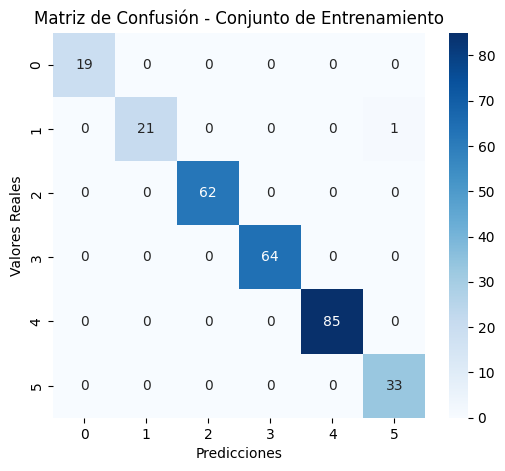

In [ ]:
# Obtener las clases únicas del target en orden
class_labels = sorted(y_train2.unique()) 

# Convertir las etiquetas de clase a cadenas
class_labels_str = [str(label) for label in class_labels]

# Generar predicciones en el conjunto de entrenamiento usando el mejor modelo encontrado
y_train_pred2 = best_xgb.predict(X_train2)

# Crear la matriz de confusión
cm2 = confusion_matrix(y_train2, y_train_pred2, labels=class_labels)

# Evaluar el rendimiento del modelo
print("Reporte de clasificación:")
print(classification_report(y_train2, y_train_pred2, target_names=class_labels_str))

# Graficar la matriz de confusión con los nombres de las clases reales
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_str, yticklabels=class_labels_str)
plt.title('Matriz de Confusión - Conjunto de Entrenamiento')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.50      0.20      0.29         5
           2       0.78      0.88      0.82        16
           3       0.76      1.00      0.86        16
           4       1.00      1.00      1.00        21
           5       0.88      0.78      0.82         9

    accuracy                           0.83        72
   macro avg       0.74      0.68      0.68        72
weighted avg       0.81      0.83      0.81        72



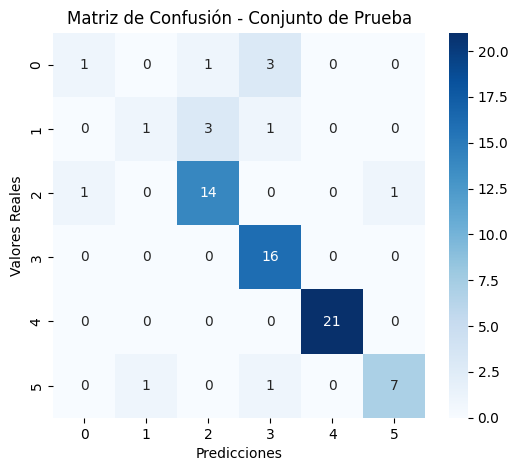

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_test_pred2 = best_xgb.predict(X_test2)

# Obtener los nombres de las clases como cadenas
class_labels = [str(label) for label in sorted(y_test2.unique())]

# Evaluar el rendimiento del modelo
print("Reporte de clasificación:")
print(classification_report(y_test2, y_test_pred2, target_names=class_labels))

# Matriz de confusión
cm2 = confusion_matrix(y_test2, y_test_pred2)

# Graficar la matriz de confusión con nombres reales
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión - Conjunto de Prueba')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

